# Выбор региона для разработки, "ГлавРосГос Нефть" 

Добывающей компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину. 
Шаги для выбора локации:
В избранном регионе собираем характеристики для скважин: качество нефти и объём её запасов;
Строим модель для предсказания объёма запасов в новых скважинах;
Выбираем скважины с самыми высокими оценками значений;
Определяем регион с максимальной суммарной прибылью отобранных скважин.
Предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Построим модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой Bootstrap.

id — уникальный идентификатор скважины;
f0, f1, f2 — три признака точек;
product — объём запасов в скважине (тыс. баррелей).

При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выберем 200 лучших для разработки.
Бюджет на разработку скважин в регионе — 10 млрд рублей.
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
После оценки рисков оставим лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирем регион с наибольшей средней прибылью.

In [1]:
import pandas as pd
import sklearn 
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# бюджет
REGION_BUDGET = 10_000_000_000
# количество скважин
NUMBER_OF_WELLS = 200
#стоимость единицы сырья
INCOME_PER_UNIT = 450_000

<div class="alert alert-block alert-success"><b>Комментарий ревьюера </b>
    
<b>Успех:</b><br>
👍 Константы оформлены согласно руководству по написанию кода на Python [PEP-8](https://pythonworld.ru/osnovy/pep-8-rukovodstvo-po-napisaniyu-koda-na-python.html#section-29)
* Для записи больших чисел и более удобного чтения, чтобы не запутаться в нулях, можно использовать еще такую запись:  `10e9`, что означает 10 * 10**9.      
</div> 

## 1. Загрузим и подготовим данные

In [3]:
try:
    data_0 = pd.read_csv('/Users/admin/Downloads/geo_data_0.csv')
    data_1 = pd.read_csv('/Users/admin/Downloads/geo_data_1.csv')
    data_2 = pd.read_csv('/Users/admin/Downloads/geo_data_2.csv')
except:
    data_0 = pd.read_csv('/datasets/geo_data_0.csv')
    data_1 = pd.read_csv('/datasets/geo_data_1.csv')
    data_2 = pd.read_csv('/datasets/geo_data_2.csv')


In [5]:
print(data_0.sample(5))
print(data_1.sample(5))
print(data_2.sample(5))

          id        f0        f1         f2     product
64367  8yF5j  1.252931 -0.488510  -0.760343   99.085892
62895  kVR9a  0.668998 -0.390542   3.052643   98.404038
16805  HpcmX -0.756267  0.901805  10.772250  153.643229
96872  sN3il  1.058225 -0.064195   2.028100   67.270938
7001   q9YrU  1.634999  0.166567   3.963883  137.166378
          id         f0         f1        f2     product
5504   Q7O1O   7.397184 -10.814944  1.991310   53.906522
78855  XMGUb -10.978308  -5.992055  0.998629   30.132364
91968  i72kb  -6.168685  -8.927826  2.007201   57.085625
39163  xT7HC   0.976269  -3.242051  3.001114   84.038886
75559  T2rop  -4.494208  -1.875884  4.997355  137.945408
          id        f0        f1        f2     product
54502  JH83J -1.542083 -1.694661  3.384286  108.777946
83570  WP0h8 -0.137598 -1.438817  4.430274  136.252424
71611  So8pP  0.406443 -0.470525  6.422480  100.812540
79027  CZxPk -1.714717  2.406218 -2.680928   57.736516
3328   j2vqc  0.827227  0.280952  4.411453  115

In [6]:
print(data_0.shape)
print(data_1.shape)
print(data_2.shape)

(100000, 5)
(100000, 5)
(100000, 5)


In [7]:
print(data_0.info())
print(data_1.info())
print(data_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column  

Итак, по каждому из трех регионов имеем информацию о 100 000 скважинах.

In [8]:
data_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [9]:
data_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [10]:
data_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [11]:
#проверяем наличие дубликатов
print(data_0.duplicated().sum())
print(data_1.duplicated().sum())
print(data_2.duplicated().sum())

0
0
0


In [12]:
print(data_0['id'].duplicated().sum())
print(data_1['id'].duplicated().sum())
print(data_2['id'].duplicated().sum())

10
4
4


Видим, что в графе id есть несколько дубликатов. Это повод уточнить у коллег, как могло случиться, что двум скважинам с разными характеристиками присвоен один и тот же id. Если внятного объяснения нет, удалю все дублирующиеся строки.

''

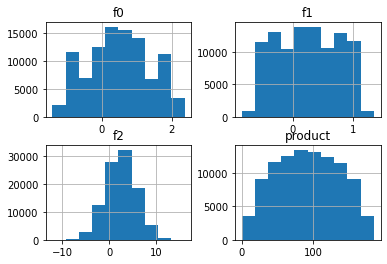

In [13]:

data_0.hist(figsize = (6,4))
;

''

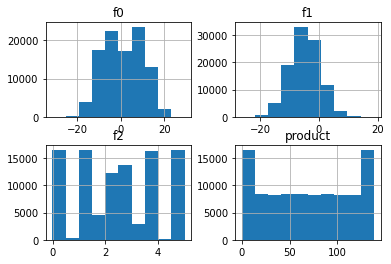

In [14]:

data_1.hist(figsize = (6,4))
;

''

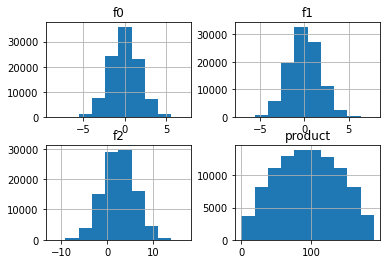

In [15]:

data_2.hist(figsize = (6,4))
;

Ожидалось увидеть нормальное, или близкое к нормальному распределению, как на графиках для третьего региона.

Особенно неожиданное распределение у второго региона. Очень много пустых скважин, и много скважин с большими запасами. А все остальные скважины поровну поделены на остальные значения.

Это можно объяснить тем, что предоставленные данные являются синтетическими.

<AxesSubplot:>

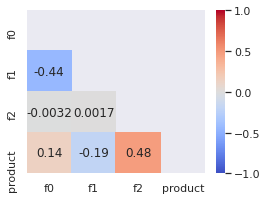

In [16]:
upp_mat = np.triu(data_0.corr())
sns.set(rc = {'figure.figsize':(4,3)})
sns.heatmap(data_0.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm', mask = upp_mat);

Высокой корреляции между признаками не выявлено

<AxesSubplot:>

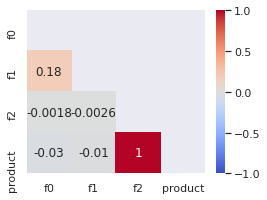

In [17]:
upp_mat = np.triu(data_1.corr())
sns.set(rc = {'figure.figsize':(4,3)})
sns.heatmap(data_1.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm', mask = upp_mat);

Видим очень высокую корреляцию между f2 и product - целквым признаком. Это говорит в пользу точности предсказаний.

<AxesSubplot:>

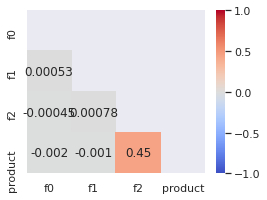

In [18]:
upp_mat = np.triu(data_2.corr())
sns.set(rc = {'figure.figsize':(4,3)})
sns.heatmap(data_2.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm', mask = upp_mat);

Корреляции между признаками также нет.

Значит, продолжаем работу со всем объемом даных

## 2. Обучим и проверим модель для каждого региона
Разобьем данные на обучающую и валидационную выборки в соотношении 75:25.

Обучим модель и сделаем предсказания на валидационной выборке.

Сохраним предсказания и правильные ответы на валидационной выборке.

Напечатаем на экране средний запас предсказанного сырья и RMSE модели.

Проанализируем результаты.

In [19]:
def spliter(data):
    # делим на признаки и результат
    features = data.drop(['product', 'id'], axis=1)
    target = data['product']
    # делим на треинровочную и валидационную выборку в соотношении 75:25
    features_train, features_valid, target_train, target_valid = train_test_split(features,
                                                                             target,test_size=0.25, 
                                                                             random_state=12345)
    return features_train, features_valid, target_train, target_valid


Удаляем из признков id - это уникальный иджентификатор, эта колонка не несет никакого смысла для обучения.

In [20]:
# для первого региона
features_train_0, features_valid_0, target_train_0, target_valid_0 = spliter(data_0)
print(features_train_0.shape)
print(features_valid_0.shape)
print(target_train_0.shape)
print(target_valid_0.shape)

(75000, 3)
(25000, 3)
(75000,)
(25000,)


In [21]:
features_train_1, features_valid_1, target_train_1, target_valid_1 = spliter(data_1)
print(features_train_1.shape)
print(features_valid_1.shape)
print(target_train_1.shape)
print(target_valid_1.shape)

(75000, 3)
(25000, 3)
(75000,)
(25000,)


In [22]:
features_train_2, features_valid_2, target_train_2, target_valid_2 = spliter(data_2)
print(features_train_2.shape)
print(features_valid_2.shape)
print(target_train_2.shape)
print(target_valid_2.shape)

(75000, 3)
(25000, 3)
(75000,)
(25000,)


Проверка показала, что выборки разделены корректно

In [23]:
def regressor(features_train, target_train, features_valid, target_valid):
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions_valid = pd.Series(model.predict(features_valid), index=features_valid.index)
    rmse = (mean_squared_error(target_valid, predictions_valid))**0.5
    return (predictions_valid, predictions_valid.mean(), rmse)


Используем индексы признаков, чтобы предсказания соответствовали таргету.

In [24]:
predicted_valid_0,mean_0, rmse_0 = regressor(features_train_0, target_train_0, features_valid_0, target_valid_0)
predicted_valid_1,mean_1, rmse_1 = regressor(features_train_1, target_train_1, features_valid_1, target_valid_1)
predicted_valid_2,mean_2, rmse_2 = regressor(features_train_2, target_train_2, features_valid_2, target_valid_2)


print('Для первой модели:')
print('Средний запас предсказанного сырья:', mean_0)
print('RMSE модели:', rmse_0)
print()
print('Для второй модели:')
print('Средний запас предсказанного сырья:', mean_1)
print('RMSE модели:', rmse_1)
print()
print('Для третьей модели:')
print('Средний запас предсказанного сырья:', mean_2)
print('RMSE модели:', rmse_2)


Для первой модели:
Средний запас предсказанного сырья: 92.59256778438035
RMSE модели: 37.5794217150813

Для второй модели:
Средний запас предсказанного сырья: 68.728546895446
RMSE модели: 0.893099286775617

Для третьей модели:
Средний запас предсказанного сырья: 94.96504596800489
RMSE модели: 40.02970873393434


Чем RMSE меньше, тем удачнее можно считать модель. По этому признаку вторая модель получилось самой удачной

## 3. Подготовимся к расчёту прибыли:

In [25]:
# посчитаем бюджет на одну скважину
well_budget = REGION_BUDGET/NUMBER_OF_WELLS
# Объем сырья безубыточной скважины
volume_of_materials = well_budget/INCOME_PER_UNIT
print('Объем сырья, достаточный для безубыточной разработки новой скважины: ', volume_of_materials)

Объем сырья, достаточный для безубыточной разработки новой скважины:  111.11111111111111


In [26]:
print(data_0['product'].mean())
print(data_1['product'].mean())
print(data_2['product'].mean())

92.50000000000001
68.82500000000002
95.00000000000004


Теперь мы знаем, сколько нефти должно быть в скважине, чтоб "выйти в ноль"

Во всех трех регионах средний объем сырья меньше достаточного объема для безубыточности. Техника "Bootstrap" позволяет оценить риск убытков при случайном отборе точек.

## 4. Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
 

In [27]:
def profit(target, predictions):
    predictions_sorted = predictions.sort_values(ascending=False)
    selected = target[predictions_sorted.index][:200]
    return INCOME_PER_UNIT*selected.sum() - REGION_BUDGET

<div class="alert alert-block alert-success"><b>Комментарий ревьюера </b>
    
<b>Успех:</b><br>
👍 Функция в порядке.
</div>

In [28]:
profit_0 = profit(target_valid_0, predicted_valid_0)
profit_1 = profit(target_valid_1, predicted_valid_1)
profit_2 = profit(target_valid_2, predicted_valid_2)
print('Прибыль для первого региона:', (profit_0/1_000_000_000).round(1), 'млрд')
print('Прибыль для второго региона:', (profit_1/1_000_000_000).round(1), 'млрд')
print('Прибыль для третьего региона:', (profit_2/1_000_000_000).round(1), 'млрд')

Прибыль для первого региона: 3.3 млрд
Прибыль для второго региона: 2.4 млрд
Прибыль для третьего региона: 2.7 млрд


Рассчетная прибыль для первого региона выше других

<div class="alert alert-block alert-success"><b>Комментарий ревьюера </b><br>
    
 Было бы здорово знать заранее 200 лучших скважин:)
</div>

## 5 Посчитаем риски и прибыль для каждого региона:
Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.

Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков.

Выберем регион для разработки скважин.

При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки. Бюджет на разработку скважин в регионе — 10 млрд рублей. При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей. После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

In [29]:
def bootstrap(predictions, target):
    state = np.random.RandomState(12345)
    values = []
    
    for i in range(1000):
        subsample = target.sample(n= 500, replace=True, random_state=state)
        subs_predictions = predictions[subsample.index]
        values.append(profit(subs_predictions,subsample))
    values = pd.Series(values)
    return values     

In [30]:
region_0 = bootstrap(target_valid_0,predicted_valid_0)
region_1 = bootstrap(target_valid_1,predicted_valid_1)
region_2 = bootstrap(target_valid_2,predicted_valid_2)

In [31]:
print('Средняя прибыль, млрд:')
print('Первый регион:',region_0.mean()/1_000_000_000)
print('Второй регион:',region_1.mean()/1_000_000_000)
print('Третий регион:',region_2.mean()/1_000_000_000)

Средняя прибыль, млрд:
Первый регион: 0.4259385269105924
Второй регион: 0.5152227734432899
Третий регион: 0.4350083627827556


In [32]:
print('Доверительный интервал:')
# print('Первый регион:', st.t.interval(0.95, len(region_0)-1,region_0.mean(), region_0.sem()))
# print('Второй регион:', st.t.interval(0.95, len(region_1)-1,region_1.mean(), region_1.sem()))
# print('Третий регион:', st.t.interval(0.95, len(region_2)-1,region_2.mean(), region_2.sem()))
regions = [region_0, region_1, region_2]
for i in regions:
    print('')
    print(i.quantile(0.025))
    print(i.quantile(0.975))

Доверительный интервал:

-102090094.83793654
947976353.3583689

68873225.37050176
931547591.2570494

-128880547.32978901
969706954.1802661


<div class="alert alert-block alert-info"><b>Комментарий студента</b>
    
Есть, поправила границы доверительного интервала <br></div> 

In [33]:
def risk_of_loss(values):
    return (values<0).sum()/values.count()

In [34]:
print('Риск убытков:')
print(risk_of_loss(region_0))
print(risk_of_loss(region_1))
print(risk_of_loss(region_2))

Риск убытков:
0.06
0.01
0.064


Во втором регионе риск убытков 1% , что меньше заданного порога.
Таким образом, можно рекомендовать для разработки скважин именно его.